In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrix
import warnings
warnings.filterwarnings("ignore")

## 첫 취업 후 1년 시점에서의 월급 변수 추출

In [2]:
data = pd.read_csv('refined0.csv') # 첫 취업 후 1년 데이터

salary = data[['sampid','fromWhen','b224', 'b225']] # ID, 조사년도, 급여 유형(연봉|월급), 급여

# 소득 유형을 월급으로 통일 (scaled_salary)
scaled_salary = []
for i in salary.index:
    if salary.loc[i]['b225'] == 9090908 or salary.loc[i]['b225'] == 9090909:
        salary.drop(i, axis=0, inplace=True)
    elif salary.loc[i]['b224'] == 1.0:
        scaled_salary.append(salary.loc[i]['b225']/12)
    elif salary.loc[i]['b224'] == 2.0:
        scaled_salary.append(salary.loc[i]['b225'])
    else:
        salary.drop(i, axis=0, inplace=True)
salary['scaled_salary']=scaled_salary

salary.head(7)

,sampid,fromWhen,b224,b225,scaled_salary
0,1,2014.0,2.0,200.0,200.0
3,7,2013.0,2.0,180.0,180.0
5,12,2014.0,2.0,150.0,150.0
6,13,2013.0,2.0,150.0,150.0
7,14,2016.0,2.0,180.0,180.0
8,15,2011.0,1.0,2160.0,180.0
9,19,2010.0,2.0,100.0,100.0


## 연도별 월급 분포 확인

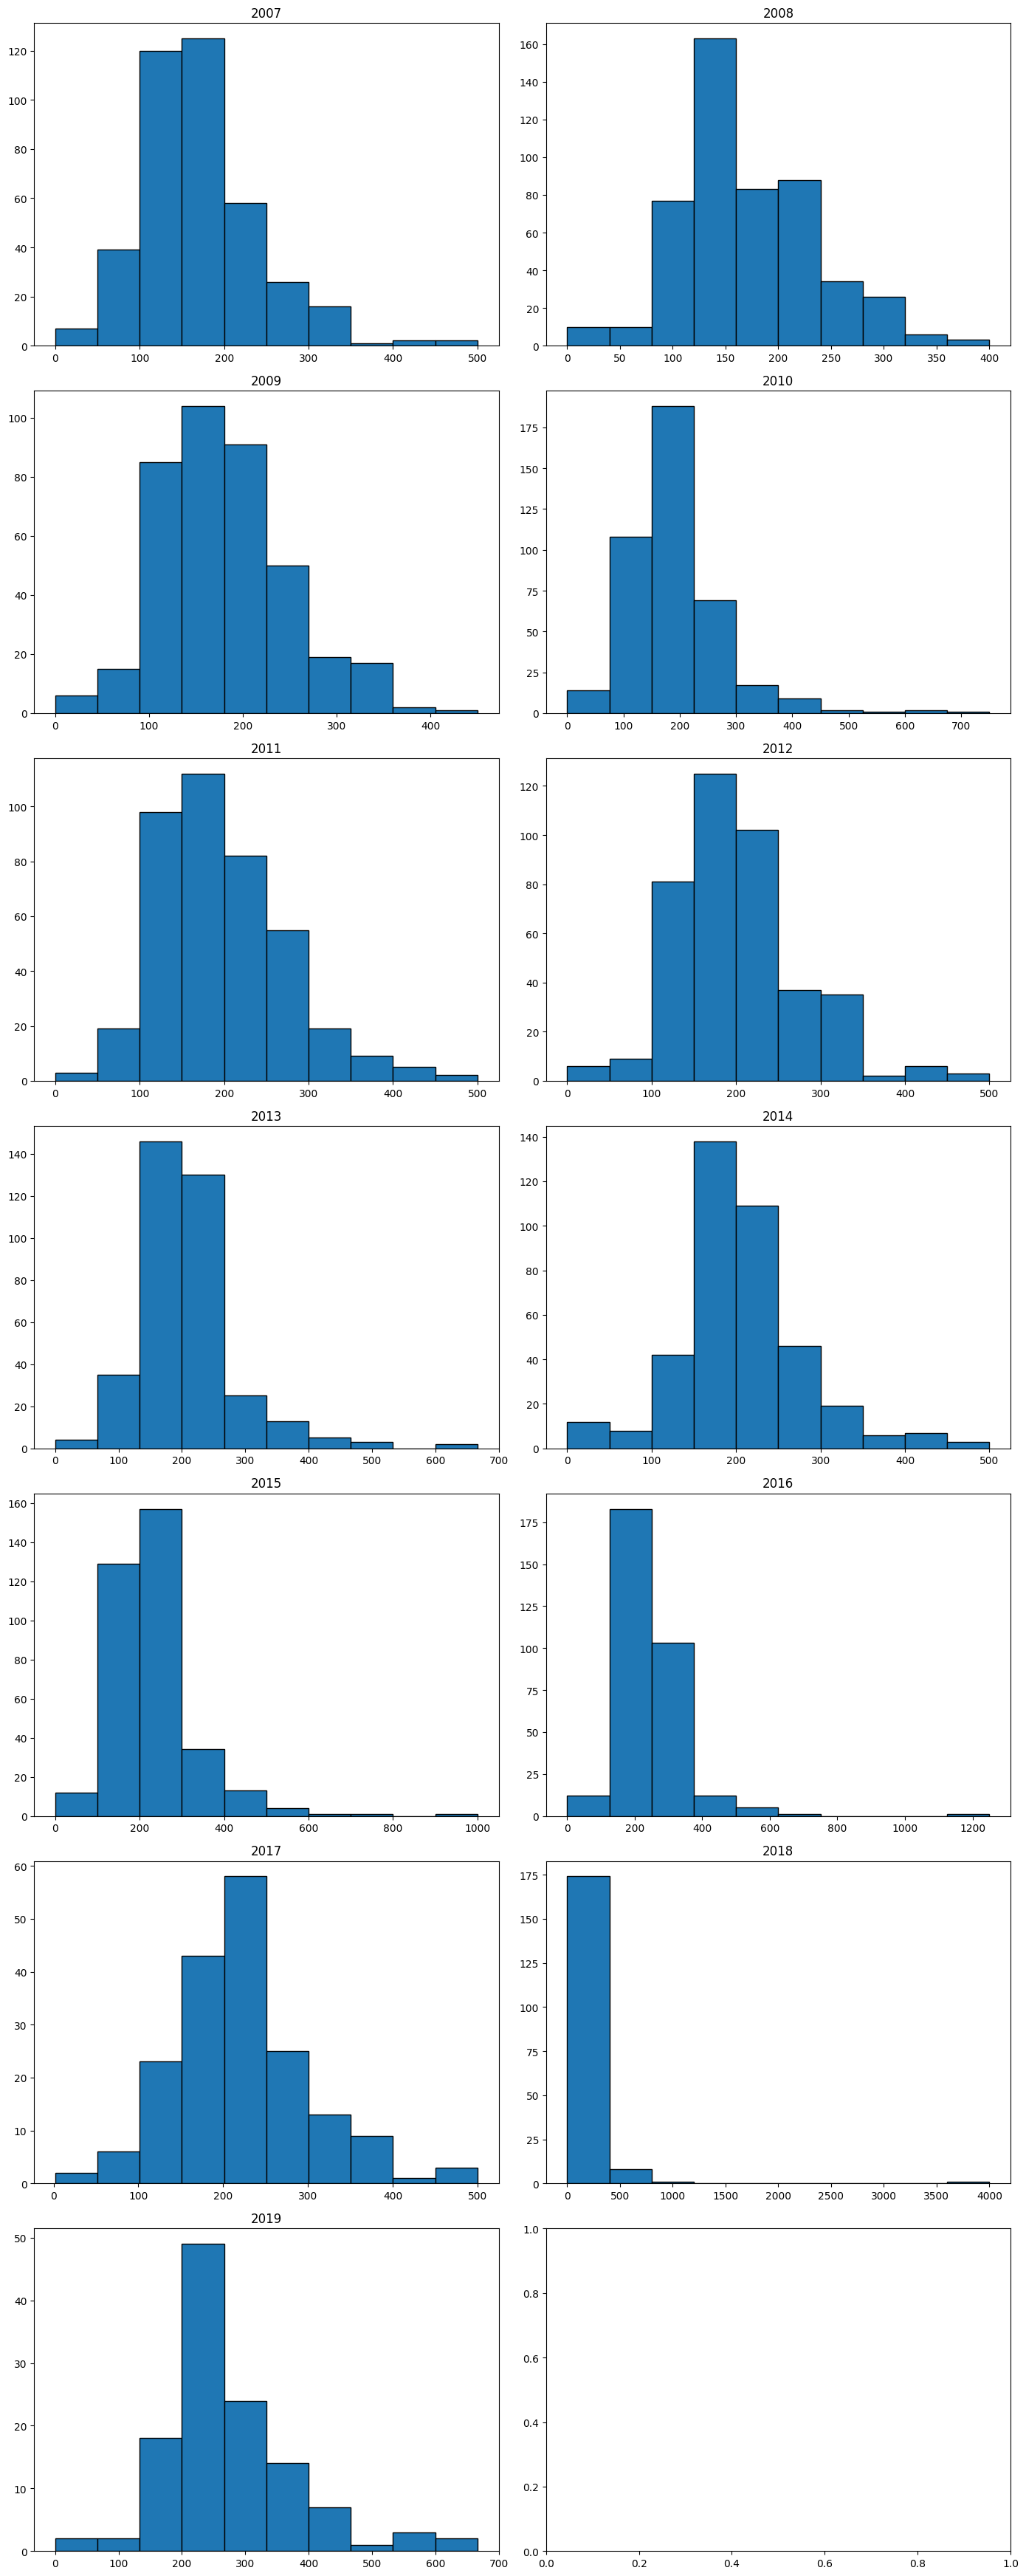

In [4]:
salary_by_year = {}
for year in range(2007, 2020):
    salary_by_year[year] = salary[salary['fromWhen'] == year]   

fig, axs = plt.subplots(7, 2, figsize=(14, 35))

for i, year in enumerate(range(2007, 2020)):
    row = i // 2
    col = i % 2
    axs[row, col].hist(salary_by_year[year]['scaled_salary'], edgecolor='black')
    axs[row, col].set_title(year)

plt.tight_layout()

In [5]:
for year in range (2007, 2020):
    print(f'''{year} - median: {np.median(salary_by_year[year]['scaled_salary']).round(2)}, mean: {np.mean(salary_by_year[year]['scaled_salary']).round(2)}''')

2007 - median: 150.0, mean: 160.91
2008 - median: 150.0, mean: 166.08
2009 - median: 170.0, mean: 178.28
2010 - median: 170.0, mean: 188.24
2011 - median: 174.17, mean: 186.58
2012 - median: 180.0, mean: 192.24
2013 - median: 191.67, mean: 200.81
2014 - median: 190.0, mean: 194.65
2015 - median: 200.0, mean: 223.53
2016 - median: 210.0, mean: 234.81
2017 - median: 230.0, mean: 232.93
2018 - median: 250.0, mean: 276.63
2019 - median: 250.0, mean: 269.15


- 연도별 월급 분포 상이 -> 연도에 따른 scaling 필요 (물가 반영)

## 연도별로 월급수준에 따른 그룹(상, 중, 하) 설정

In [6]:
# 2016 ~ 2019 데이터는 KOSIS 제공 중위소득 데이터 활용
p20 = [100, 100, 108, 116] # 연도별 소득 하위 20% percentile 
p40 = [167, 173, 183, 198] # 연도별 소득 하위 40% percentile
p60 = [251, 261, 269, 282] # 연도별 소득 하위 60% percentile
p80 = [410, 425, 436, 448] # 연도별 소득 하위 80% percentile

# ~20%, 20~40%, 40~60%, 60~80%, 80~100% 5개의 그룹으로 분류
to_p20 = []
to_p40 = []
to_p60 = []
to_p80 = []
to_p100 = []

for year in range(2016, 2020):
    for i in salary_by_year[year]['sampid']:
        scaled_salary = salary_by_year[year]['scaled_salary'][salary_by_year[year]['sampid']==i].values[0]
        if scaled_salary <= p20[year-2016]:
            to_p20.append(i)
        elif scaled_salary <= p40[year-2016]:
            to_p40.append(i)
        elif scaled_salary <= p60[year-2016]:
            to_p60.append(i)
        elif scaled_salary <= p80[year-2016]:
            to_p80.append(i)
        else:
            to_p100.append(i)
print("Samples of 2016 ~ 2019: ")            
print(f" num of ~20%: {len(to_p20)}")
print(f" num of 20~40%: {len(to_p40)}")
print(f" num of 40~60%: {len(to_p60)}")
print(f" num of 60~80%: {len(to_p80)}")
print(f" num of 80~100%: {len(to_p100)}")
print("\n")

# 2007 ~ 2015 데이터는 YP2007 데이터 내의 percentile 값 활용
# ~25% -> low, 25~75% -> mid, 75~100% -> high 3개의 그룹으로 분류

low = []
mid = []
high = []

for year in range(2007, 2016):
    for i in salary_by_year[year]['sampid']:
        scaled_salary = salary_by_year[year]['scaled_salary'][salary_by_year[year]['sampid']==i].values[0]
        if scaled_salary <= np.percentile(salary_by_year[year]['scaled_salary'], 25):
            low.append(i)
        elif scaled_salary <= np.percentile(salary_by_year[year]['scaled_salary'], 75):
            mid.append(i)
        else:
            high.append(i)

print("Samples of 2007 ~ 2015: ")
print(f" num of low: {len(low)}")
print(f" num of mid: {len(mid)}")
print(f" num of high: {len(high)}")
print("\n")

# 2016 ~ 2019 데이터: ~40% -> low에 추가, 40~60% -> mid에 추가 60~100% -> high에 추가
low.extend(to_p20)
low.extend(to_p40)
mid.extend(to_p60)
high.extend(to_p80)
high.extend(to_p100)

low.sort()
mid.sort()
high.sort()

print("Samples of 2007 ~ 2019: ")
print(f" num of low: {len(low)}")
print(f" num of mid: {len(mid)}")
print(f" num of high: {len(high)}")

Samples of 2016 ~ 2019: 
 num of ~20%: 30
 num of 20~40%: 118
 num of 40~60%: 413
 num of 60~80%: 213
 num of 80~100%: 32


Samples of 2007 ~ 2015: 
 num of low: 1025
 num of mid: 1752
 num of high: 835


Samples of 2007 ~ 2019: 
 num of low: 1173
 num of mid: 2165
 num of high: 1080


## 물가 반영 변수 price_level 생성 (월급/최저시급)

In [7]:
salary['price_level'] = 1 # salary df에 새 변수(price_level) 추가
minimum_wage = [3480, 3770, 4000, 4110, 4320, 4580, 4860, 5210, 5580, 6030, 6470, 7530, 8350] # 2007 ~ 2019 최저시급

# 연도별로 각 연도에 해당하는 최저시급을 월급(sclaed_salary)에 나누어 price_level 변수에 저장
years = list(range(2007, 2020)) 
for i in salary.index:
    for j in years:
        if salary.loc[i]['fromWhen'] == j:
            salary.loc[i,'price_level'] = salary.loc[i]['scaled_salary']/minimum_wage[years.index(j)]*10000

salary.head()

,sampid,fromWhen,b224,b225,scaled_salary,price_level
0,1,2014.0,2.0,200.0,200.0,383.877159
3,7,2013.0,2.0,180.0,180.0,370.370370
5,12,2014.0,2.0,150.0,150.0,287.907869
6,13,2013.0,2.0,150.0,150.0,308.641975
7,14,2016.0,2.0,180.0,180.0,298.507463


## 대학교 4학년 시점에서의 유의한 학교생활 변수 추출 - 범주형

a039: 
Chi2 Stat: 18.508608138334566
p-value: 0.017720411323622894
Degrees of Freedom: 8
Expected Frequencies:
[[  1.91817216  10.74176408  97.63496281 234.01700319  16.68809777]
 [  4.79277365  26.83953241 243.95217853 584.7183847   41.69713071]
 [  3.2890542   18.41870351 167.41285866 401.26461211  28.61477152]]
True




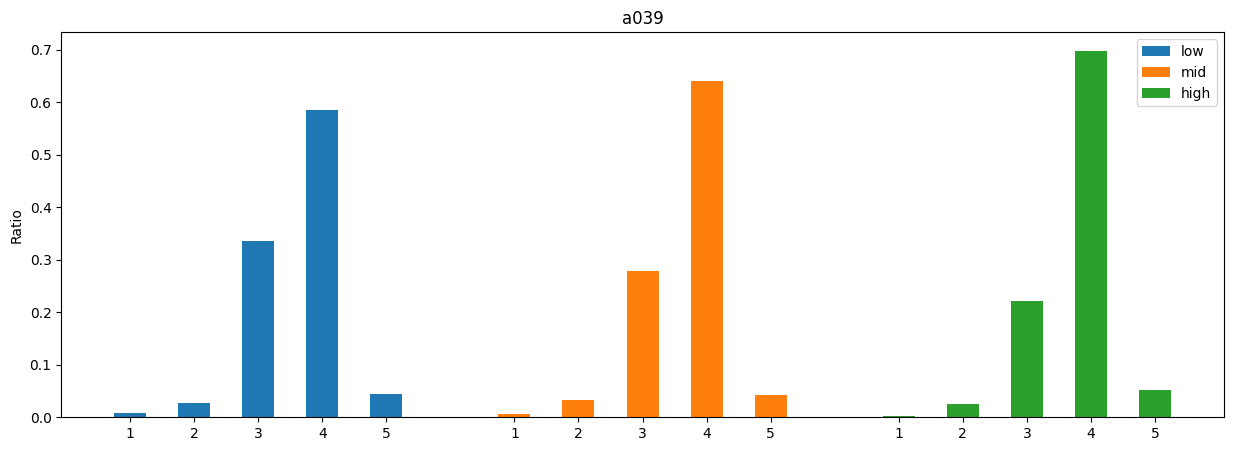



a041: 
Chi2 Stat: 18.446992111914852
p-value: 0.018113940704110702
Degrees of Freedom: 8
Expected Frequencies:
[[  2.30180659  14.76992561 105.11583422 215.60255048  23.2098831 ]
 [  5.75132837  36.90435707 262.64399575 538.7077577   57.99256111]
 [  3.94686504  25.32571732 180.24017003 369.68969182  39.79755579]]
True




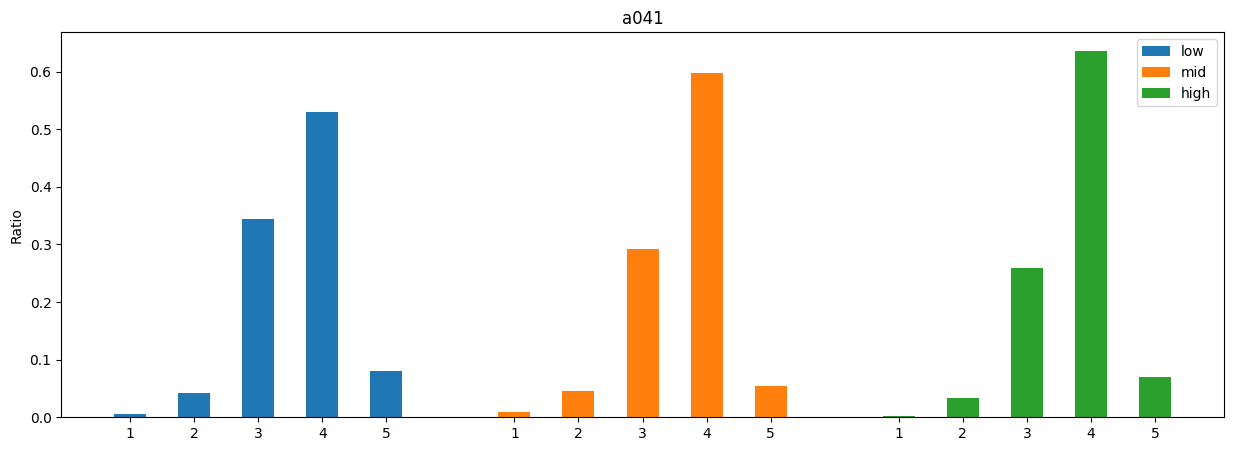



a043: 
Chi2 Stat: 20.083521745527143
p-value: 0.01002463718130421
Degrees of Freedom: 8
Expected Frequencies:
[[  2.4936238   13.81083953 102.62221041 216.75345377  25.31987248]
 [  6.23060574  34.50797024 256.41339001 541.58342189  63.26461211]
 [  4.27577046  23.68119022 175.96439957 371.66312434  43.41551541]]
True




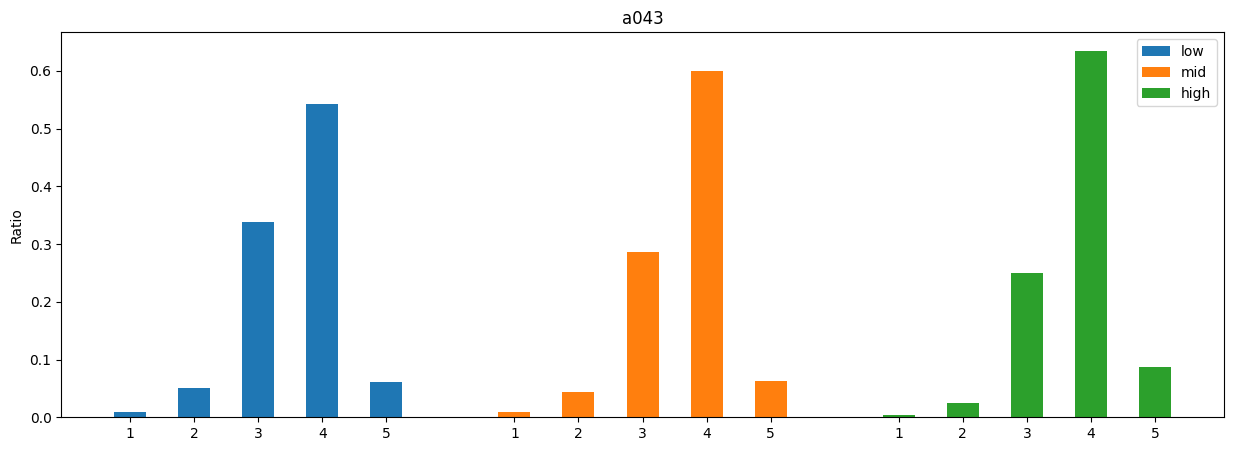



a045: 
Chi2 Stat: 22.534044971653127
p-value: 0.00401693362467539
Degrees of Freedom: 8
Expected Frequencies:
[[  4.98078975  24.13767343 159.19370331 149.99839915  20.68943436]
 [ 12.47278549  60.44503735 398.64941302 375.62273212  51.81003202]
 [  8.54642476  41.41728922 273.15688367 257.37886873  35.50053362]]
True




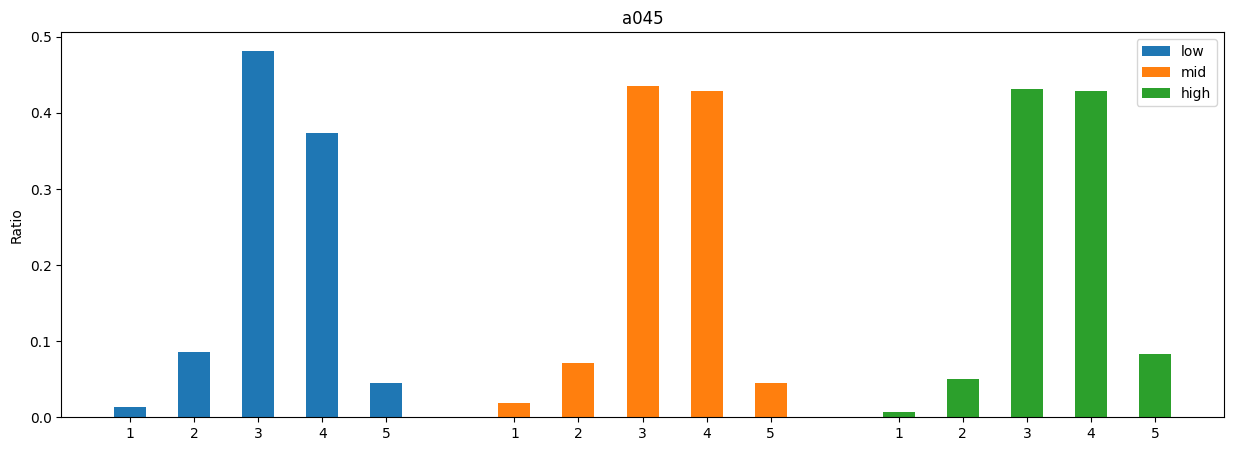



a046: 
Chi2 Stat: 42.09064019322624
p-value: 1.3022212148489846e-06
Degrees of Freedom: 8
Expected Frequencies:
[[  4.34381551  28.33822502 118.1104123  129.07337526  16.13417191]
 [ 10.16981132  66.34591195 276.52201258 302.18867925  37.77358491]
 [  6.48637317  42.31586303 176.36757512 192.73794549  24.09224319]]
True




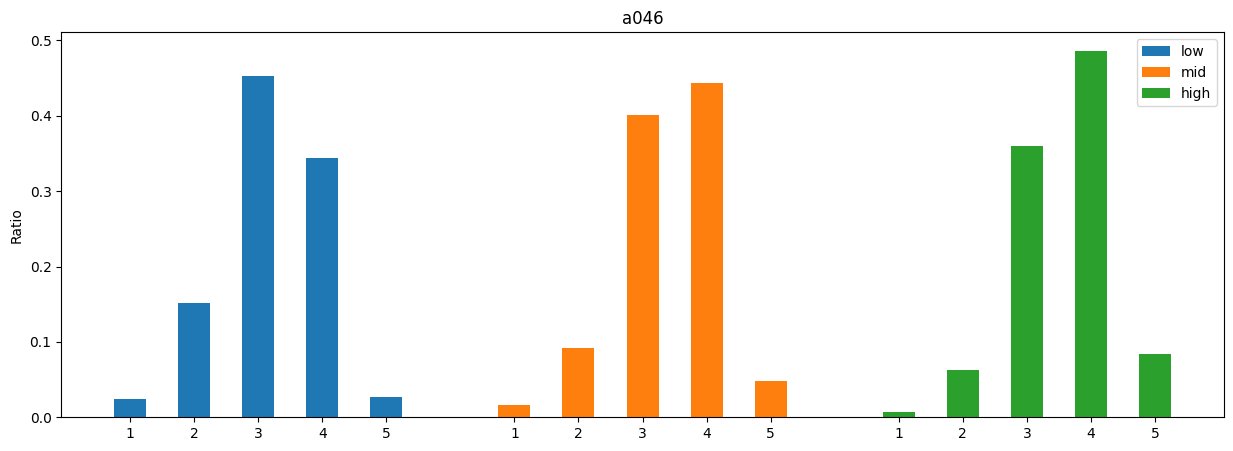



a047: 
Chi2 Stat: 40.614218188248785
p-value: 2.4609710280897823e-06
Degrees of Freedom: 8
Expected Frequencies:
[[ 20.47798742  76.12019567 101.35569532  84.80782669  13.2382949 ]
 [ 47.94339623 178.21383648 237.29559748 198.55345912  30.99371069]
 [ 30.57861635 113.66596785 151.3487072  126.63871419  19.76799441]]
True




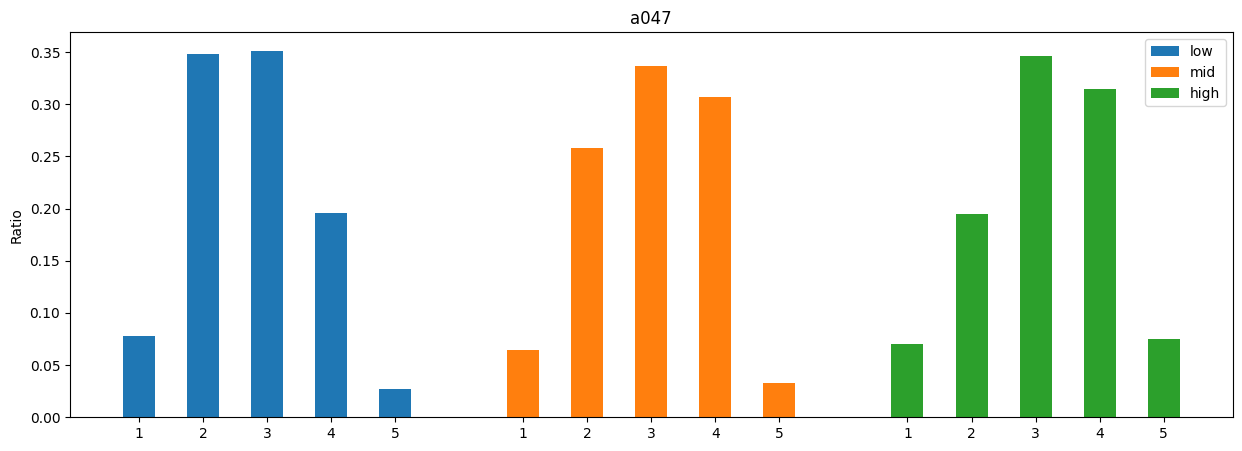



a059: 
Chi2 Stat: 33.84183255266794
p-value: 4.339665861288574e-05
Degrees of Freedom: 8
Expected Frequencies:
[[ 87.64548852 190.85958356  71.69247197   8.64922584   1.15323011]
 [219.35718099 477.6791244  179.43032568  21.64709023   2.8862787 ]
 [148.99733049 324.46129204 121.87720235  14.70368393   1.96049119]]
True




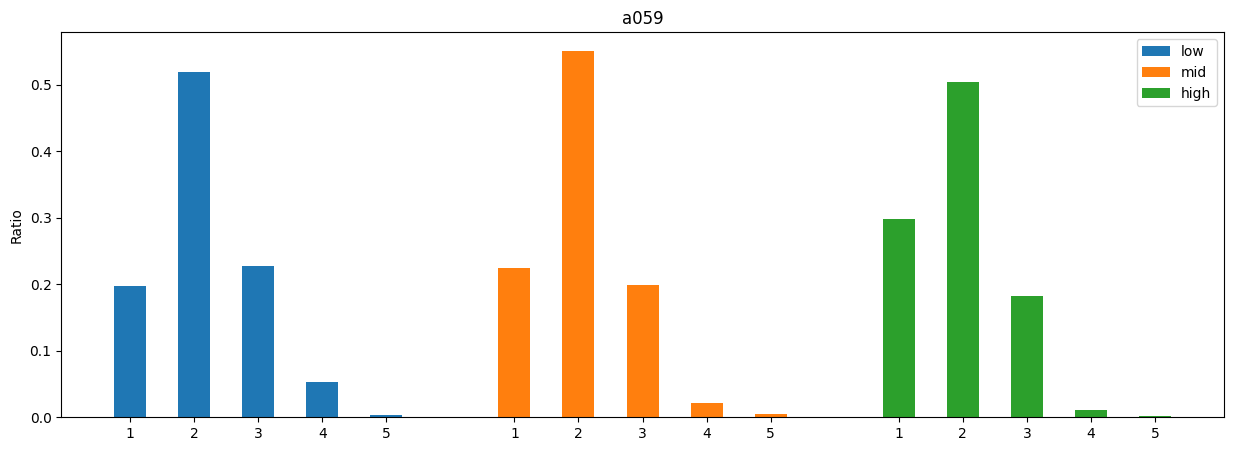



a065: 
Chi2 Stat: 31.242170687124364
p-value: 2.2788031227306703e-05
Degrees of Freedom: 6
Expected Frequencies:
[[122.4345969  210.27229044  26.33208756   0.96102509]
 [306.42658836 526.2648158   65.90336359   2.40523225]
 [208.13881474 357.46289375  44.76454885   1.63374266]]
True




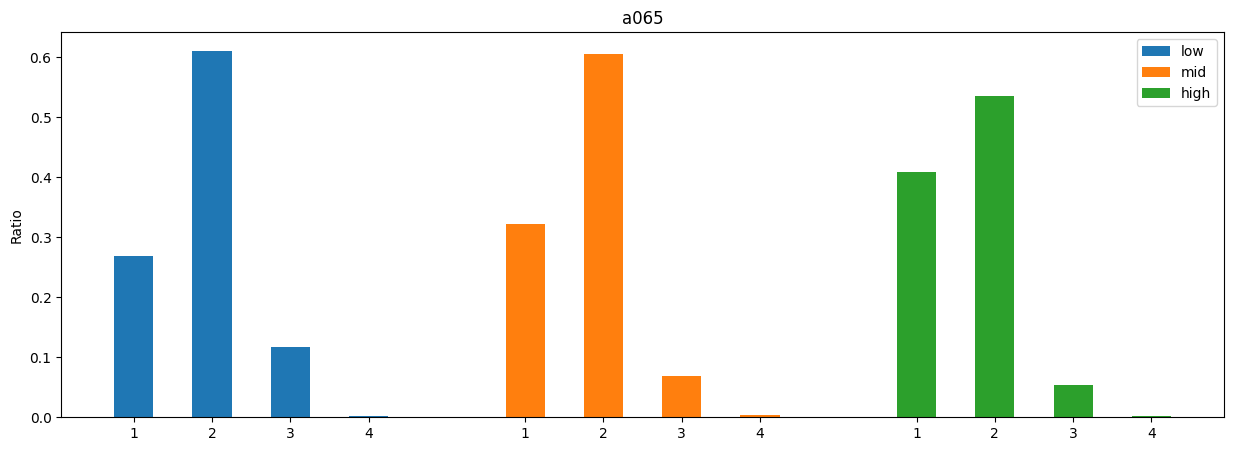



a080: 
Chi2 Stat: 28.119803710425526
p-value: 0.0004519966844917233
Degrees of Freedom: 8
Expected Frequencies:
[[ 24.45544554  11.66336634   1.31683168   3.00990099 358.55445545]
 [ 62.82413956  29.96228194   3.38283828   7.73220179 921.09853843]
 [ 42.7204149   20.37435172   2.30033003   5.25789722 626.34700613]]
True




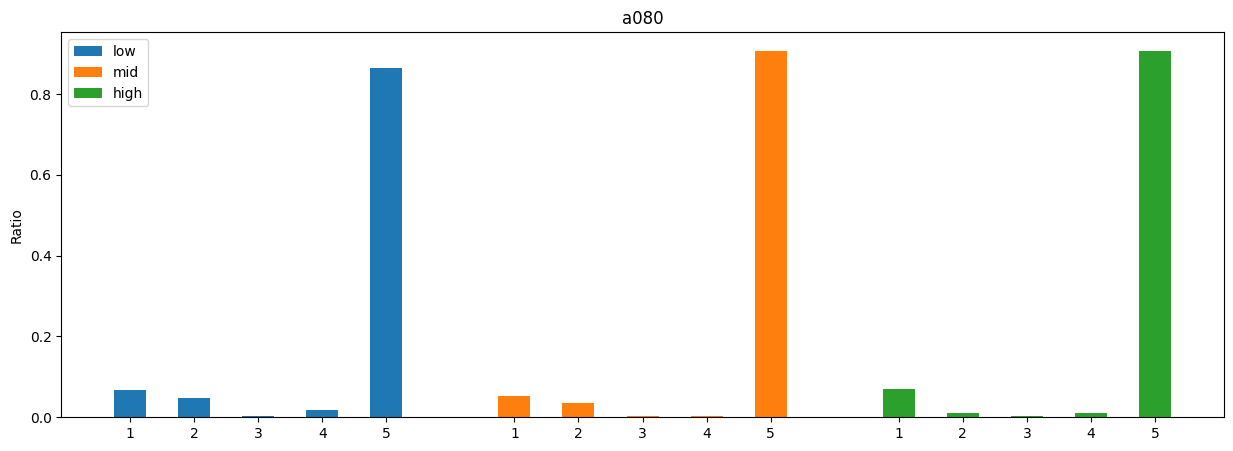



a225: 
Chi2 Stat: 18.378952254920623
p-value: 0.00010210834245534115
Degrees of Freedom: 2
Expected Frequencies:
[[ 45.82835821 138.17164179]
 [131.75652985 397.24347015]
 [ 89.41511194 269.58488806]]
True




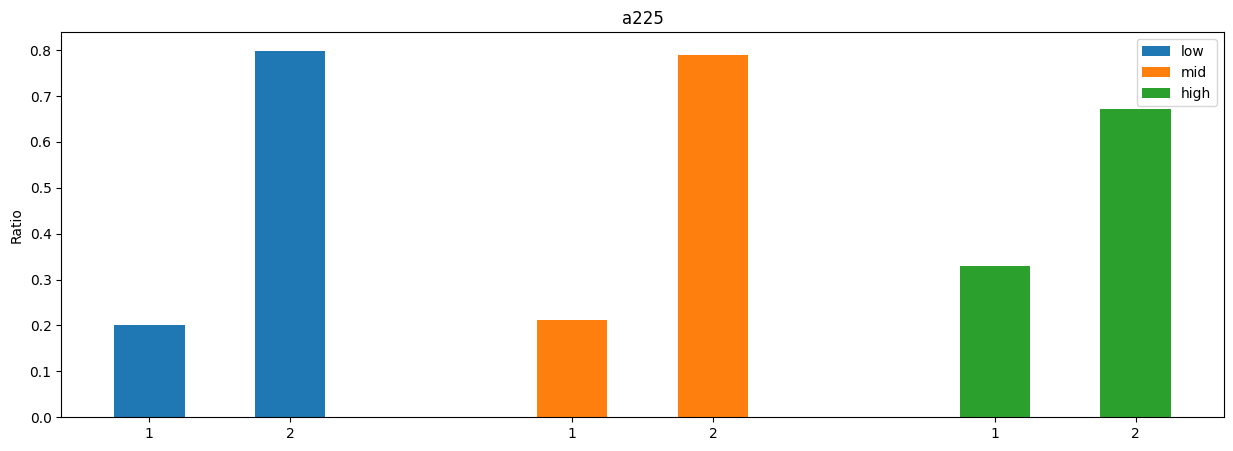



a228: 
Chi2 Stat: 9.363155532618187
p-value: 0.009264385314840955
Degrees of Freedom: 2
Expected Frequencies:
[[ 52.4137931  112.5862069 ]
 [149.93521421 322.06478579]
 [101.65099269 218.34900731]]
True




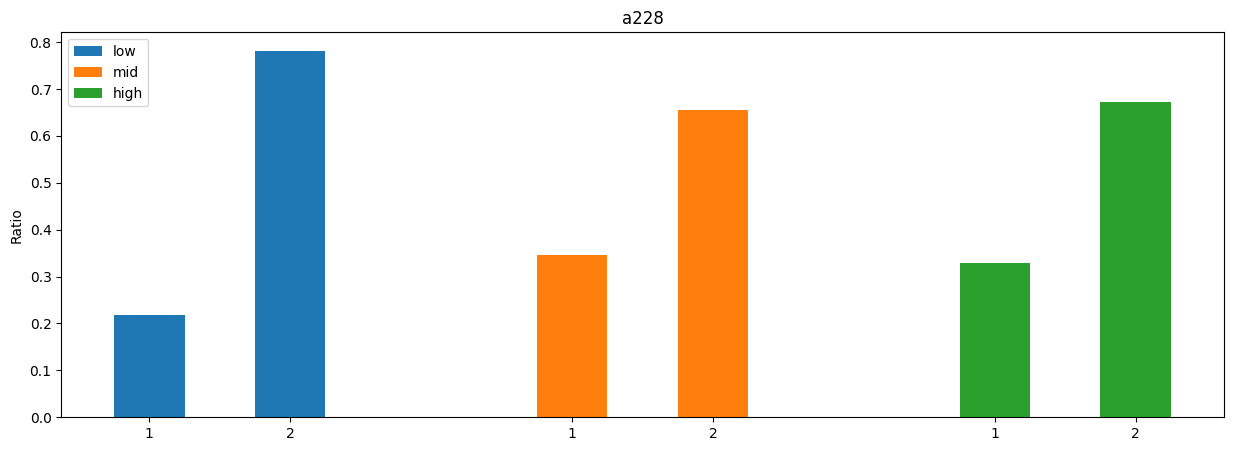



a229: 
Chi2 Stat: 11.13709290347762
p-value: 0.0038160231771465895
Degrees of Freedom: 2
Expected Frequencies:
[[ 55.78358209 128.21641791]
 [160.37779851 368.62220149]
 [108.8386194  250.1613806 ]]
True




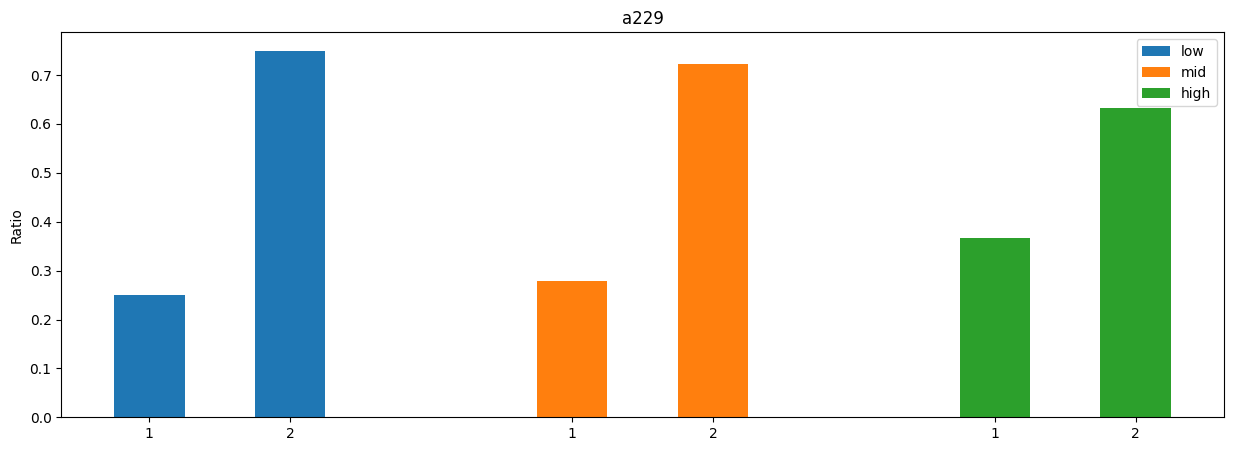



a231: 
Chi2 Stat: 18.264816809780967
p-value: 0.0001081049109246816
Degrees of Freedom: 2
Expected Frequencies:
[[ 19.91044776 164.08955224]
 [ 57.24253731 471.75746269]
 [ 38.84701493 320.15298507]]
True




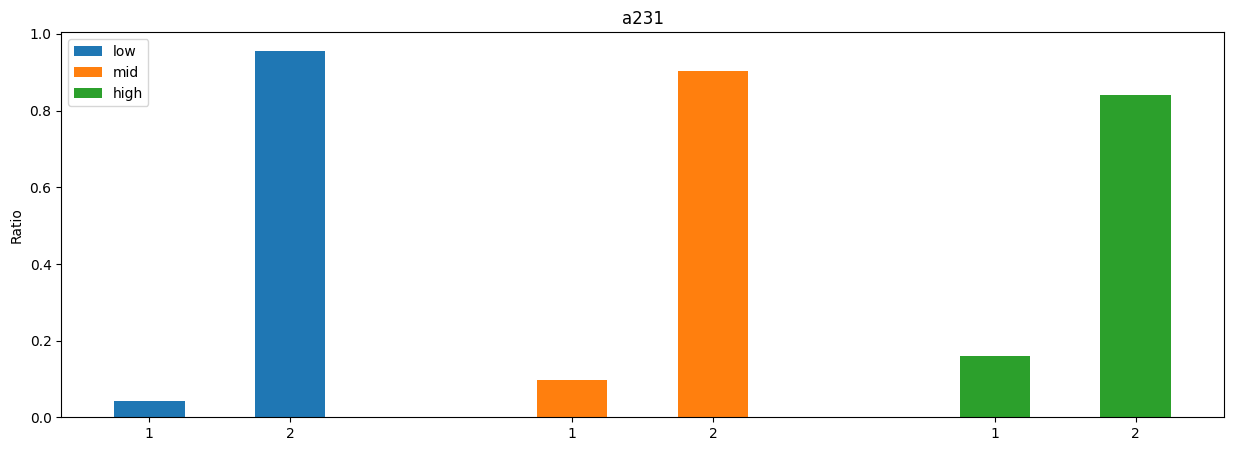



a232: 
Chi2 Stat: 47.407381651763885
p-value: 5.0771252058840784e-11
Degrees of Freedom: 2
Expected Frequencies:
[[ 76.89552239 107.10447761]
 [221.07462687 307.92537313]
 [150.02985075 208.97014925]]
True




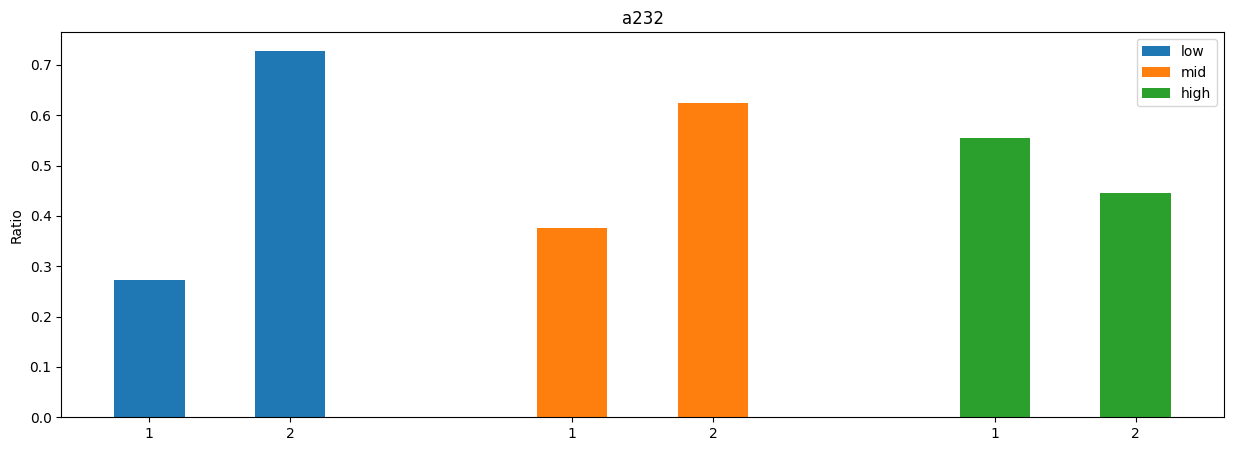



a233: 
Chi2 Stat: 50.79150736905551
p-value: 9.348981729188771e-12
Degrees of Freedom: 2
Expected Frequencies:
[[ 47.71641791 136.28358209]
 [137.18470149 391.81529851]
 [ 93.0988806  265.9011194 ]]
True




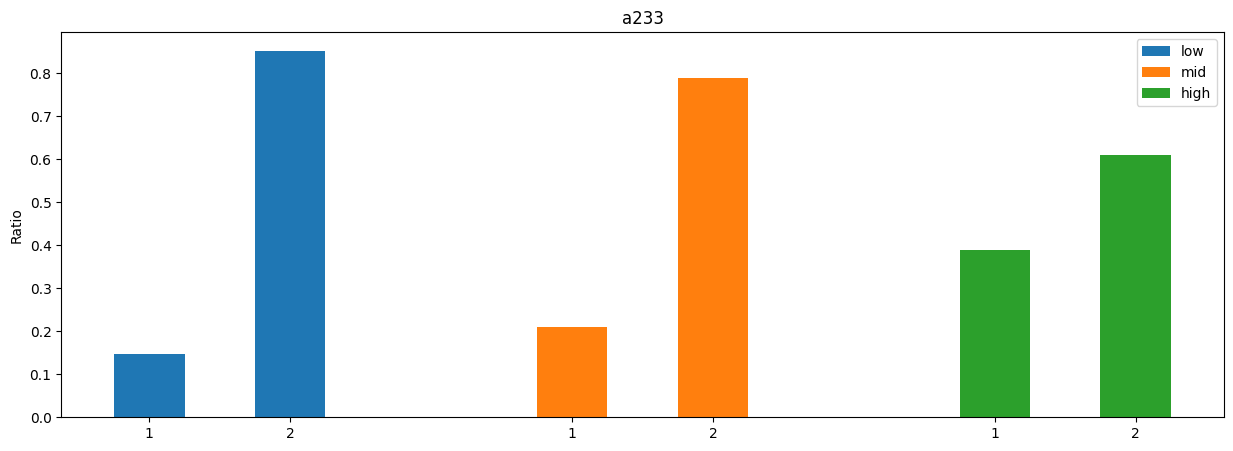



a234: 
Chi2 Stat: 7.093791123390055
p-value: 0.028813952086617352
Degrees of Freedom: 2
Expected Frequencies:
[[ 13.81695568  87.18304432]
 [ 35.70520231 225.29479769]
 [ 21.477842   135.522158  ]]
True




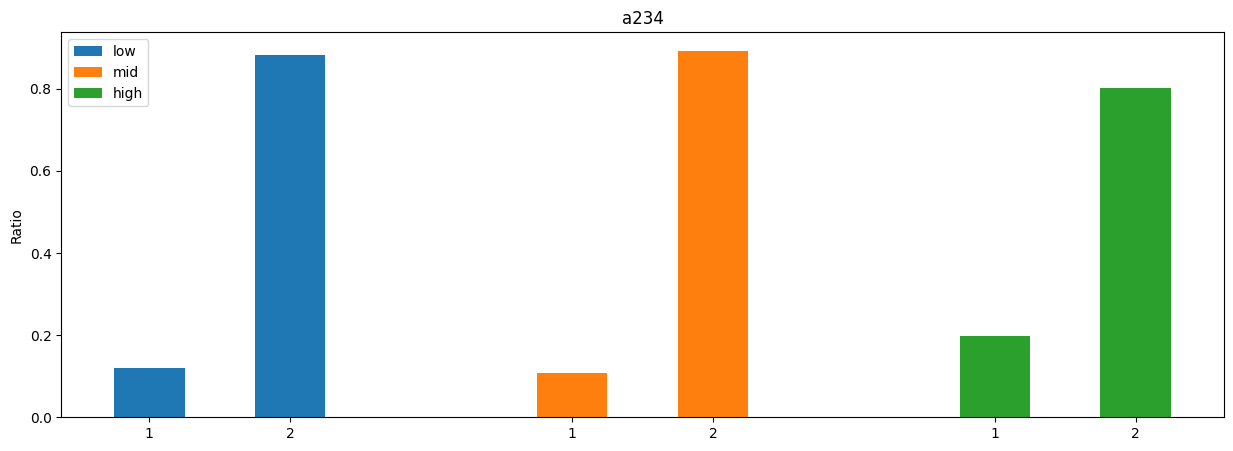



a266: 
Chi2 Stat: 18.157874873365223
p-value: 0.00011404272071178347
Degrees of Freedom: 2
Expected Frequencies:
[[ 48.53273138  37.46726862]
 [125.84650113  97.15349887]
 [ 75.62076749  58.37923251]]
True




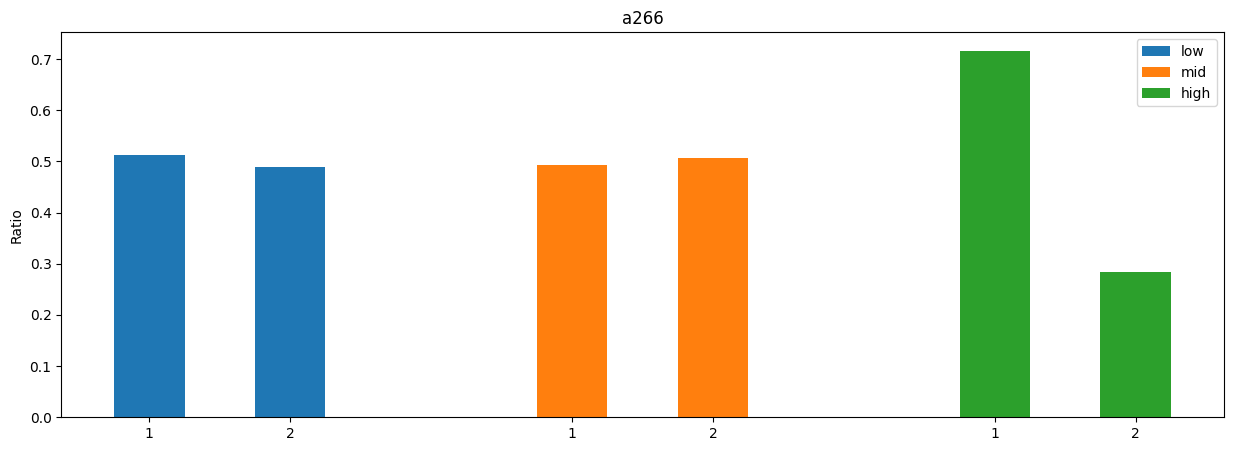



a267: 
Chi2 Stat: 10.51172889818746
p-value: 0.005216834654230065
Degrees of Freedom: 2
Expected Frequencies:
[[ 37.85553047  48.14446953]
 [ 98.16027088 124.83972912]
 [ 58.98419865  75.01580135]]
True




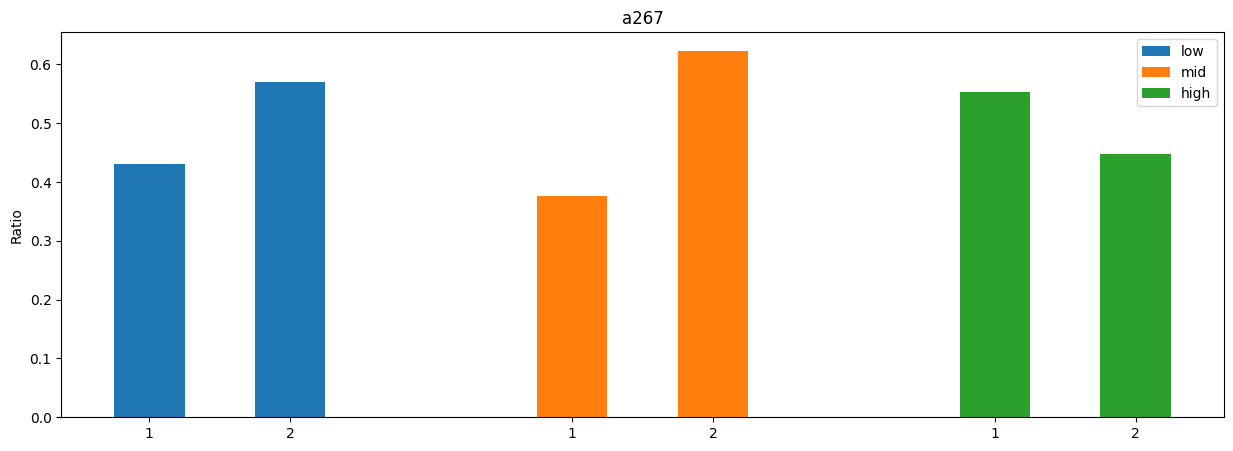



a271: 
Chi2 Stat: 9.626528776814903
p-value: 0.008121305284477482
Degrees of Freedom: 2
Expected Frequencies:
[[ 33.39051919  52.60948081]
 [ 86.58239278 136.41760722]
 [ 52.02708804  81.97291196]]
True




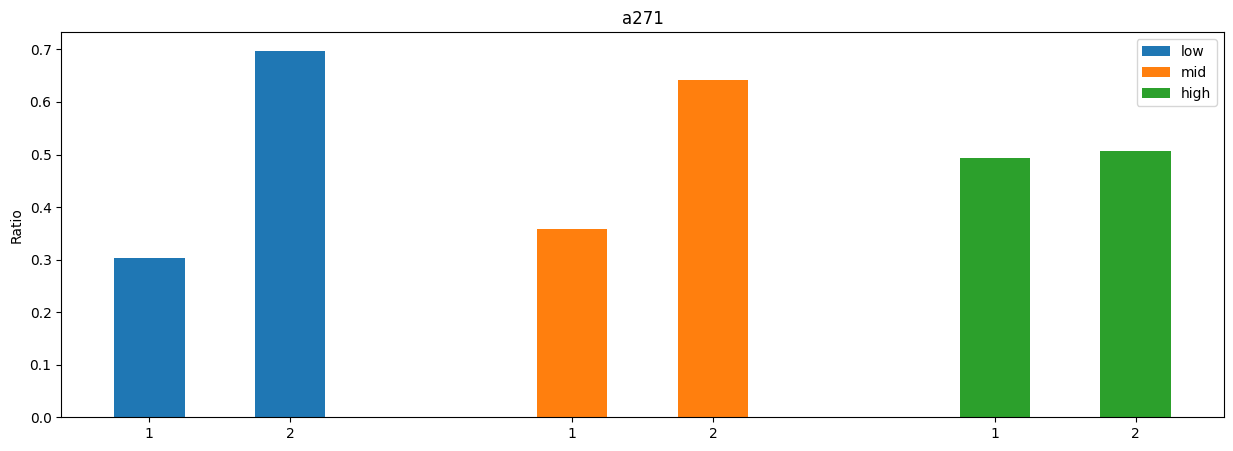



a362: 
Chi2 Stat: 16.644246537279994
p-value: 0.03403422120779066
Degrees of Freedom: 8
Expected Frequencies:
[[  0.97065463   4.27088036  21.93679458  51.83295711   6.98871332]
 [  2.51693002  11.0744921   56.88261851 134.40406321  18.12189616]
 [  1.51241535   6.65462754  34.18058691  80.76297968  10.88939052]]
True




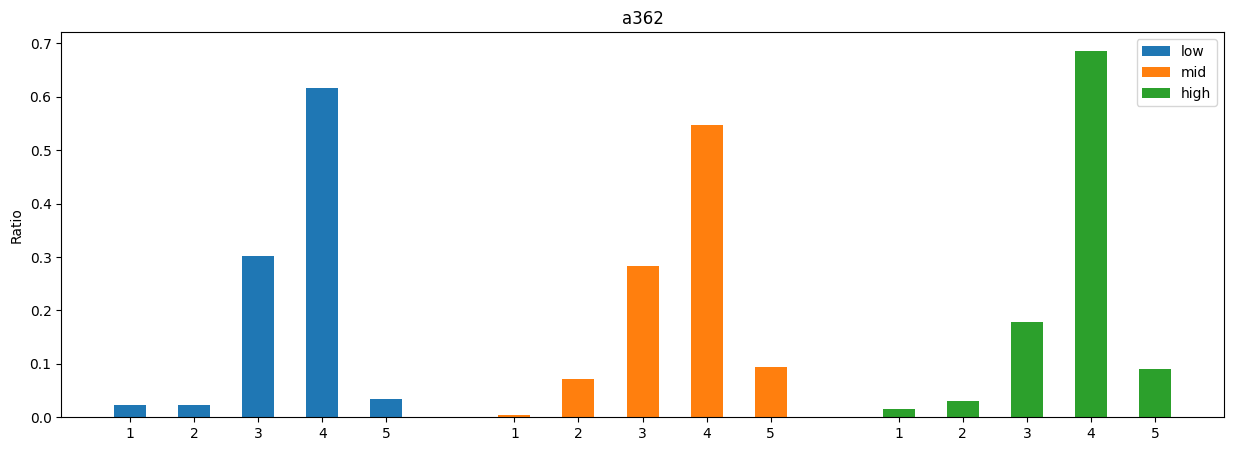



a254: 
Chi2 Stat: 17.531447541428363
p-value: 0.025027115686384327
Degrees of Freedom: 8
Expected Frequencies:
[[  6.29254658  48.6242236  111.74037267 114.21925466  26.12360248]
 [ 16.11055901 124.49068323 286.08447205 292.4310559   66.88322981]
 [ 10.59689441  81.88509317 188.17515528 192.34968944  43.9931677 ]]
True




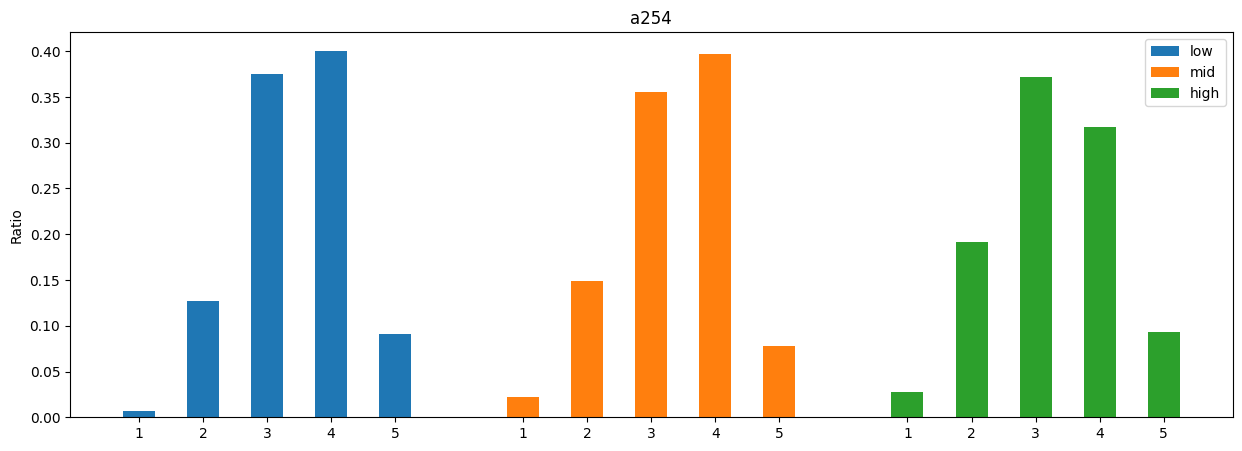



a401: 
Chi2 Stat: 6.984096667088552
p-value: 0.03043846015375567
Degrees of Freedom: 2
Expected Frequencies:
[[ 71.8426276  327.1573724 ]
 [184.19801512 838.80198488]
 [124.95935728 569.04064272]]
True




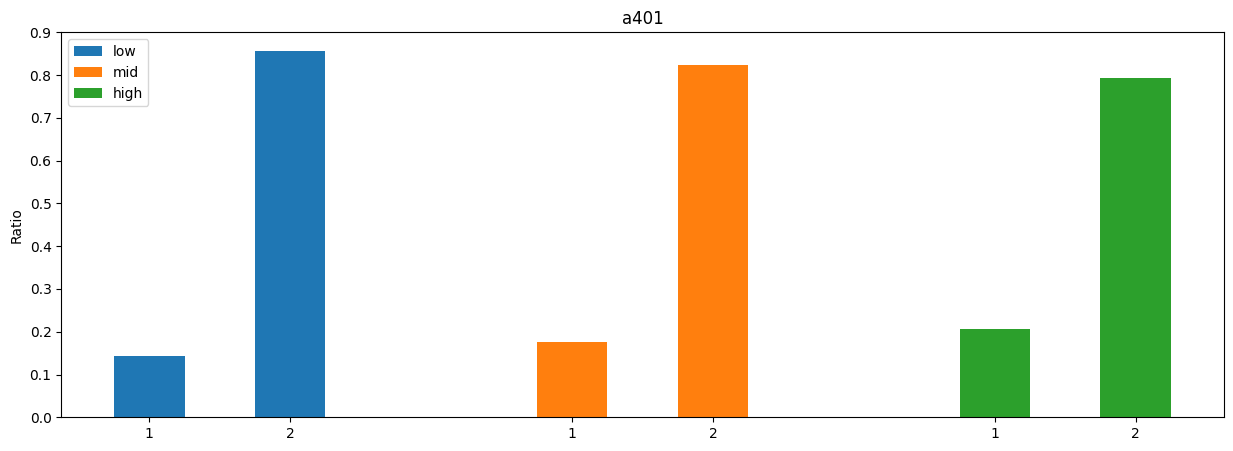



a501: 
Chi2 Stat: 10.492186807083222
p-value: 0.005268058430659445
Degrees of Freedom: 2
Expected Frequencies:
[[121.52779097 274.47220903]
 [311.1847981  702.8152019 ]
 [213.28741093 481.71258907]]
True




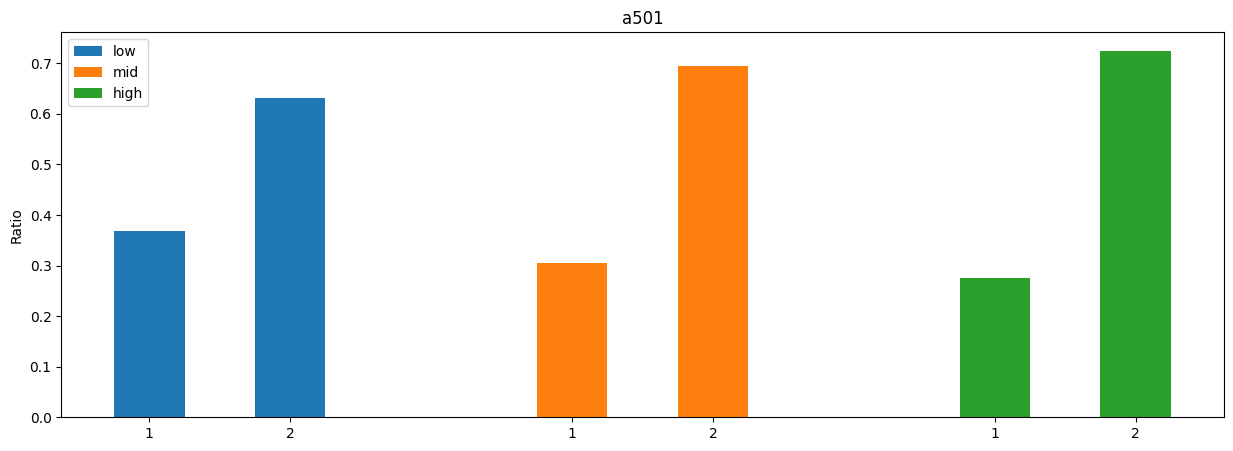

In [8]:
univ_data = pd.read_csv('new_hn4data.csv', encoding='cp949') # 대학교 4학년 시점에 응답한 데이터

# 소득 수준별 대학생활 데이터 그룹화
univ_data_low = univ_data[univ_data['sampid'].isin(low)] 
univ_data_mid = univ_data[univ_data['sampid'].isin(mid)]
univ_data_high = univ_data[univ_data['sampid'].isin(high)]

# 범주형 변수가 아니거나 NaN 값이 많아 사용할 수 없는 변수 제거
univ_data_group = univ_data.drop(columns = ['a048', 'a076','a084', 'a086',  
                                            'a085', 'a087', 'a088', 'a089', 'a090', 'a091', 'a092', 
                                            'a093', 'a094', 'a095', 'a096', 'a097', 'a098', 'a099', 
                                            'a100', 'a101', 'a102', 'a103', 'a106', 'a107', 'a108',
                                            'a109', 'a110', 'a111', 'a112', 'a113', 'a114', 'a115',
                                            'a116', 'a117', 'a118', 'a119', 'a120', 'a120', 'a121', 
                                            'a122', 'a123', 'a124', 'a248', 'a250', 'a251', 'a433',
                                            'a434', 'a435', 'a441', 'a442', 'a443', 'a507', 'a508', 
                                            'a514'])

variables = univ_data_group.keys()[2:] # sampid를 제외한 독립변수 

# 유의한 변수 저장용 빈 list
sig_variables = []

# 모든 독립변수에 대해 카이제곱 검정 시행 - 소득수준에 따른 학교 생활 변수의 분포 차이 검정

group_low, group_mid, group_high = {}, {}, {} # group 할당용 빈 list
freq_low, freq_mid, freq_high = {}, {}, {} # 빈도수 계산용 빈 list
cross_tab = {} # cross tabel 생성용 빈 list
ratio_low, ratio_mid, ratio_high = {}, {}, {} # barplot용 빈 list

for i  in variables :
    # 소득 수준에 따라 NaN값 제거 후 세 그룹으로 분할
    group_low[i] = univ_data_low[(univ_data_low[i].notna()) & (univ_data_low[i] != 9090909) & (univ_data_low[i] != 9090908)][i]
    group_mid[i] = univ_data_mid[(univ_data_mid[i].notna()) & (univ_data_mid[i] != 9090909) & (univ_data_mid[i] != 9090908)][i]  
    group_high[i] = univ_data_high[(univ_data_high[i].notna()) & (univ_data_high[i] != 9090909) & (univ_data_high[i] != 9090908)][i]

    # 나눈 그룹에서 빈도수 계산
    freq_low[i] = group_low[i].value_counts().reindex(range(1, (len(group_low[i].unique())+1)), fill_value=0)
    freq_mid[i] = group_mid[i].value_counts().reindex(range(1, (len(group_mid[i].unique())+1)), fill_value=0)
    freq_high[i] = group_high[i].value_counts().reindex(range(1, (len(group_high[i].unique())+1)), fill_value=0)

    # 빈도 수 기준 cross table 생성
    cross_tab[i] = pd.DataFrame({'low': freq_low[i], 'mid': freq_mid[i], 'high': freq_high[i]}).T

    # 카이제곱 검정 시행
    chi2, p, dof, expected = chi2_contingency(cross_tab[i])

    # p-value가 0.05보다 작은 경우 유의한 변수로 취급
    if p < 0.05:
        # 유의한 경우에만 카이제곱 검정 결과 출력
        print(f'''{i}: ''')
        print("Chi2 Stat:", chi2)
        print("p-value:", p)
        print("Degrees of Freedom:", dof)
        print("Expected Frequencies:")
        print(expected)
        print(p < 0.05)
        print('\n')
        
        # 유의한 변수 sig_variables list에 저장
        sig_variables.append(i)

        # 비율 기준으로 barplot 생성
        ratio_low[i] = freq_low[i] / freq_low[i].sum()
        ratio_mid[i] = freq_mid[i] / freq_mid[i].sum()
        ratio_high[i] = freq_high[i] / freq_high[i].sum()

        # 그룹 간의 간격 설정
        index1 = np.arange(len(ratio_low[i]))
        index2 = index1 + len(ratio_mid[i]) + 1  
        index3 = index2 + len(ratio_high[i]) + 1
        
        # 그래프 크기 설정
        plt.figure(figsize=(15, 5))
        bar_width = 0.5
        plt.bar(index1, ratio_low[i], width=bar_width, label=f'low')
        plt.bar(index2, ratio_mid[i], width=bar_width, label=f'mid')
        plt.bar(index3, ratio_high[i], width=bar_width, label=f'high')
        
        # x축 눈금 및 레이블 설정
        all_indices = np.concatenate([index1, index2, index3])
        labels = list(freq_low[i].keys()) * 3
        plt.xticks(all_indices, labels)
        
        # 레이블 및 제목 설정
        plt.ylabel('Ratio')
        plt.title(f'{i}')
        
        # 범례 추가
        plt.legend()
        
        # 그래프 표시
        plt.savefig(f'''{i}''')
        plt.show()
        print('\n')

## 대학교 4학년 시점에서의 유의한 학교생활 변수 추출 - 연속형

In [9]:
# 연속형 변수 'aa48'(친한 친구 수)에 대해 F검정 시행

# NaN값 제거 후 연속형 변수 데이터프레임 생성
df_con = univ_data[['sampid', 'a048']].dropna()

# 데이터프레임에 소득수준 그룹 변수 추가
df_con['salary_level'] = 1
for i in df_con.index:
    if df_con.loc[i, 'sampid'] in low:
        df_con.loc[i, 'salary_level'] = 'low'
    elif df_con.loc[i, 'sampid'] in mid:
        df_con.loc[i, 'salary_level'] = 'mid'
    elif df_con.loc[i, 'sampid'] in high:
        df_con.loc[i, 'salary_level'] = 'high'

# F 검정 시행

model = smf.ols('a048 ~ C(salary_level)', data=df_con).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  
f_value = anova_table['F'][0]
p_value = anova_table['PR(>F)'][0]

print(f"Variable: a048, F-value: {f_value:.2f}, p-value: {p_value:.4f}")

Variable: a048, F-value: 0.92, p-value: 0.4292


In [10]:
# 연속형 변수가 유의하지 않으므로 sig_variables 23개만으로 회귀분석 진행
print(f" the number of independent variables: {len(variables)}")
print(f" the number of significant independent variables: {len(sig_variables)}")

 the number of independent variables: 180
 the number of significant independent variables: 23


## 독립변수 간 상관관계 파악

In [11]:
# 4학년 시점 데이터에서 유의한 변수만 남김
df_filtered = univ_data[['sampid'] + sig_variables]
df_filtered.head()

,sampid,a039,a041,a043,a045,a046,a047,a059,a065,a080,...,a232,a233,a234,a266,a267,a271,a362,a254,a401,a501
0,1,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0,5.0,...,1.0,2.0,2.0,1.0,1.0,1.0,4.0,4.0,2.0,1.0
1,2,3.0,4.0,4.0,3.0,4.0,2.0,3.0,2.0,5.0,...,1.0,2.0,2.0,1.0,2.0,2.0,4.0,3.0,2.0,1.0
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [12]:
# 대학-소득 데이터 병합
merged_df = pd.merge(df_filtered, salary, on='sampid', how='inner')
merged_df.head()

,sampid,a039,a041,a043,a045,a046,a047,a059,a065,a080,...,a271,a362,a254,a401,a501,fromWhen,b224,b225,scaled_salary,price_level
0,1,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0,5.0,...,1.0,4.0,4.0,2.0,1.0,2014.0,2.0,200.0,200.0,383.877159
1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2013.0,2.0,180.0,180.0,370.370370
2,12,4.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,5.0,...,NaN,NaN,3.0,2.0,2.0,2014.0,2.0,150.0,150.0,287.907869
3,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2013.0,2.0,150.0,150.0,308.641975
4,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016.0,2.0,180.0,180.0,298.507463


In [13]:
# 물가지수 제외 소득 데이터 제거
merged_df.drop(columns=['fromWhen', 'b224', 'b225', 'scaled_salary'], inplace=True)
merged_df.head()

,sampid,a039,a041,a043,a045,a046,a047,a059,a065,a080,...,a233,a234,a266,a267,a271,a362,a254,a401,a501,price_level
0,1,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0,5.0,...,2.0,2.0,1.0,1.0,1.0,4.0,4.0,2.0,1.0,383.877159
1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,370.370370
2,12,4.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,5.0,...,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.0,287.907869
3,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,308.641975
4,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,298.507463


In [14]:
# NaN 행 제거
df_cleaned = merged_df.dropna()
df_cleaned.head()

,sampid,a039,a041,a043,a045,a046,a047,a059,a065,a080,...,a233,a234,a266,a267,a271,a362,a254,a401,a501,price_level
0,1,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0,5.0,...,2.0,2.0,1.0,1.0,1.0,4.0,4.0,2.0,1.0,383.877159
9,23,4.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,5.0,...,1.0,2.0,2.0,1.0,2.0,4.0,3.0,1.0,2.0,322.580645
10,24,4.0,4.0,4.0,4.0,3.0,3.0,2.0,2.0,5.0,...,2.0,2.0,2.0,2.0,1.0,4.0,3.0,2.0,2.0,618.238022
12,26,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,5.0,...,2.0,2.0,2.0,2.0,2.0,4.0,3.0,2.0,2.0,483.870968
14,32,3.0,4.0,4.0,4.0,3.0,4.0,2.0,2.0,5.0,...,2.0,2.0,2.0,2.0,1.0,4.0,4.0,2.0,2.0,298.507463


In [15]:
# 독립변수 인코딩
df_features = df_cleaned.drop(columns=['sampid', 'price_level'])
df_encoded = pd.get_dummies(df_features)
df_encoded.head()

,a039,a041,a043,a045,a046,a047,a059,a065,a080,a225,...,a232,a233,a234,a266,a267,a271,a362,a254,a401,a501
0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0,5.0,2.0,...,1.0,2.0,2.0,1.0,1.0,1.0,4.0,4.0,2.0,1.0
9,4.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,5.0,2.0,...,1.0,1.0,2.0,2.0,1.0,2.0,4.0,3.0,1.0,2.0
10,4.0,4.0,4.0,4.0,3.0,3.0,2.0,2.0,5.0,2.0,...,2.0,2.0,2.0,2.0,2.0,1.0,4.0,3.0,2.0,2.0
12,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,5.0,2.0,...,1.0,2.0,2.0,2.0,2.0,2.0,4.0,3.0,2.0,2.0
14,3.0,4.0,4.0,4.0,3.0,4.0,2.0,2.0,5.0,2.0,...,1.0,2.0,2.0,2.0,2.0,1.0,4.0,4.0,2.0,2.0


In [16]:
# binary 뱐수 2 -> 0으로 변환 (아니오)
binary = ['a225','a228','a229','a232','a233','a266','a501']

for i in binary:
    for j in df_encoded.index:
        if df_encoded[i].loc[j] == 2.0:
            df_encoded.loc[j, i] = 0.0

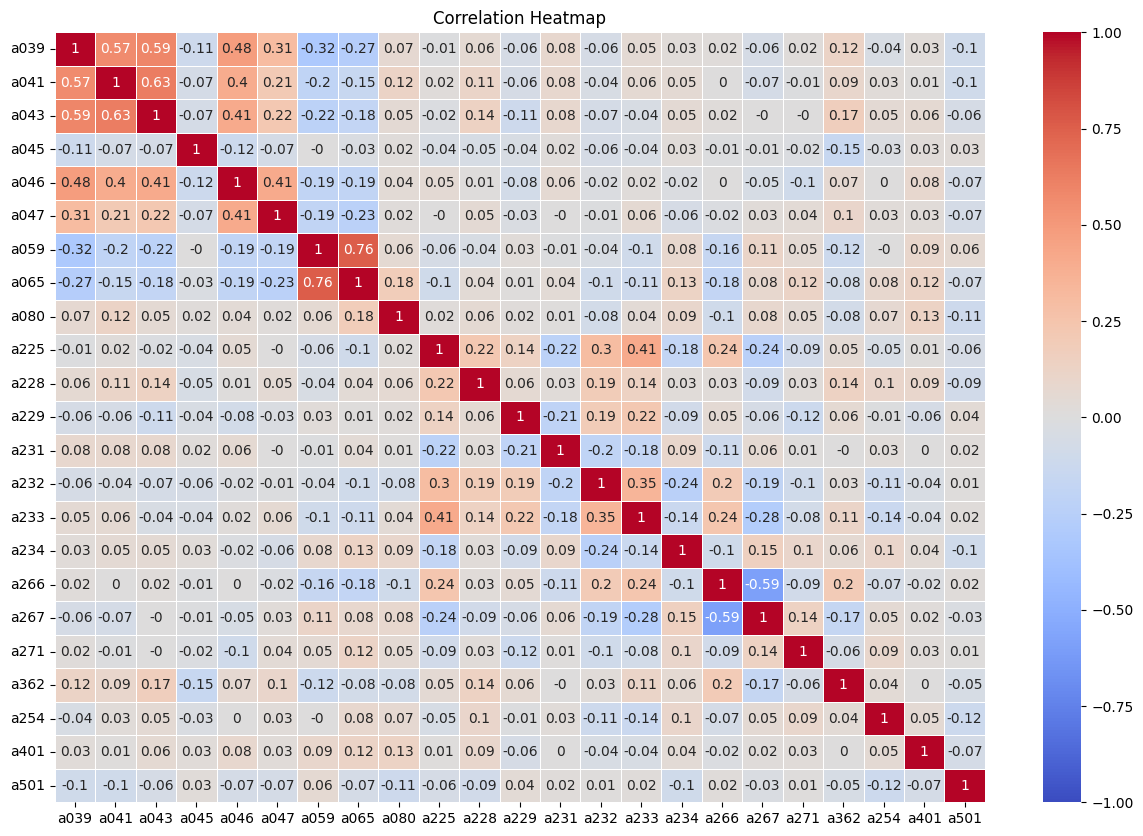

In [17]:
corr_matrix = df_encoded.corr().round(2)
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## 회귀분석

In [18]:
# 설명력 겹치거나 유의하지 않은 변수 제거 후 최종 변수
selected_features = ['a232','a229', 'a233', 'a362', 'a228', 'a254', 'a046', 'a065', 'a041']

# 최종변수 VIF 확인
df_selected = df_encoded[selected_features]
df_selected.replace([np.inf, -np.inf], np.nan, inplace=True)
df_selected.dropna(inplace=True)
df_selected['Intercept'] = 1
vif_data = pd.DataFrame()
vif_data['Feature'] = df_selected.columns
vif_data['VIF'] = [variance_inflation_factor(df_selected.values, i) for i in range(df_selected.shape[1])]
vif_data.sort_values(by='VIF', ascending=False)

,Feature,VIF
9,Intercept,92.037449
8,a041,1.231926
6,a046,1.225851
2,a233,1.219890
0,a232,1.213451
4,a228,1.096834
1,a229,1.081931
7,a065,1.079465
5,a254,1.047994
3,a362,1.045097


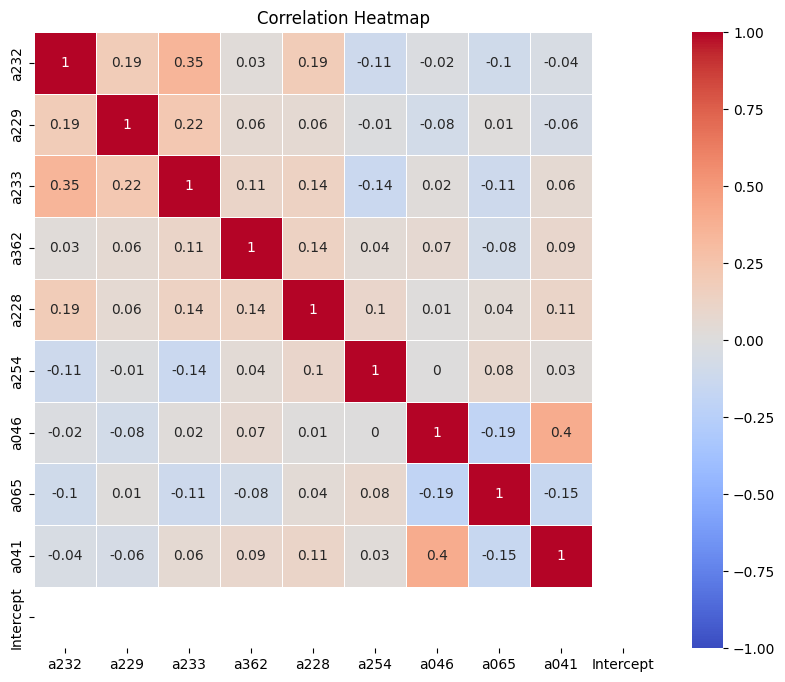

In [19]:
# 최종변수 상관관계 히트맵
corr_matrix = df_selected.corr().round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [20]:
# 종속변수 분리
y = df_cleaned['price_level']
X = df_selected

print("\nIndependent features:")
print(X)
print("\nTarget variable:")
print(y)

# 상수항 추가
X = sm.add_constant(X)

# 회귀 모델 훈련
model = sm.OLS(y, X).fit()

# 회귀 분석 결과 출력
print("\nRegression results:")
print(model.summary())


Independent features:
      a232  a229  a233  a362  a228  a254  a046  a065  a041  Intercept
0      1.0   1.0   0.0   4.0   1.0   4.0   4.0   2.0   4.0          1
9      1.0   0.0   1.0   4.0   1.0   3.0   4.0   2.0   4.0          1
10     0.0   1.0   0.0   4.0   1.0   3.0   3.0   2.0   4.0          1
12     1.0   0.0   0.0   4.0   0.0   3.0   4.0   1.0   4.0          1
14     1.0   1.0   0.0   4.0   1.0   4.0   3.0   2.0   4.0          1
...    ...   ...   ...   ...   ...   ...   ...   ...   ...        ...
4352   0.0   0.0   0.0   3.0   0.0   2.0   3.0   1.0   4.0          1
4364   1.0   1.0   0.0   4.0   0.0   4.0   3.0   1.0   4.0          1
4387   1.0   0.0   0.0   3.0   0.0   4.0   4.0   1.0   3.0          1
4401   1.0   1.0   1.0   4.0   0.0   1.0   5.0   2.0   4.0          1
4417   1.0   0.0   0.0   3.0   1.0   4.0   3.0   2.0   4.0          1

[443 rows x 10 columns]

Target variable:
0       383.877159
9       322.580645
10      618.238022
12      483.870968
14      298.507463